In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

plt.rc('font', family='serif')
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=10, color='grey')
plt.rc('ytick', labelsize=10, color='grey')
plt.rc('legend', fontsize=12, loc='lower left')
plt.rc('figure', titlesize=12)
plt.rc('savefig', dpi=330, bbox='tight')
%matplotlib inline

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [74]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import skew

In [75]:
import sys
PATH_TO_ROOT = 'C:\\Users\\kushs\\Downloads\\Electricity usage prediction\\Electricity usage prediction'
sys.path.insert(0,PATH_TO_ROOT)

In [76]:
def generate_fig_path(fig_name):

    return '{}/results/fig/model comparison/{}'.format(PATH_TO_ROOT, fig_name)

def generate_input_data_path(data_name):
    
    return '{}/results/data/predict/{}.csv'.format(PATH_TO_ROOT, data_name)

def generate_result_data_path(data_name):
    
    return '{}/results/data/{}.csv'.format(PATH_TO_ROOT, data_name)

In [77]:
cities = ['Mumbai', 'Hyderabad', 'Delhi']

In [78]:
def combine_predict(region):
    lgbm_predict = pd.read_csv(generate_input_data_path(f'lgbm_{region}'),index_col=0)[['yhat_lgbm']]
    otherML_predict = pd.read_csv(generate_input_data_path(f'otherML_{region}'),index_col=0)[['yhat_rf','yhat_svm','yhat_nn']]
    linear_predict = pd.read_csv(generate_input_data_path(f'linear_{region}'),index_col=0)[['y','yhat_hcdh','yhat_5p']]
    prophet_predict = pd.read_csv(generate_input_data_path(f'prophet_{region}'),index_col=0)[['yhat_prophet','train']]

    predict = pd.concat([lgbm_predict, otherML_predict, linear_predict, prophet_predict], axis=1)
    predict.index = pd.to_datetime(predict.index)

    predict.rename(columns={'y':'Ground Truth',
                            'yhat_5p':'5-Parameter',
                            'yhat_hcdh':'Degree Hour',
                            'yhat_prophet':'Decomposed',
                            'yhat_lgbm':'lightGBM',
                            'yhat_rf':'Random Forest',
                            'yhat_svm':'Support Vector Machine',
                            'yhat_nn':'Neural Network'}, inplace=True)
    predict.fillna(value=0, inplace=True)
    return predict

In [79]:
mum_predict = combine_predict('mum')
hyd_predict = combine_predict('hyd')
delhi_predict = combine_predict('delhi')

In [80]:
def calculate_error(predict):
    accCom = pd.DataFrame(columns=['R2_train','R2_test','MAE_train','MAE_test','RMSE_train','RMSE_test',
                                   'CVRMSE_train','CVRMSE_test'])
    accCom['R2_train'] = predict[predict['train']].loc[:,['Ground Truth','5-Parameter','Degree Hour','Decomposed',
                        'lightGBM','Random Forest','Support Vector Machine','Neural Network']].corr().iloc[0,1:]
    accCom['R2_test'] = predict[~predict['train']].loc[:,['Ground Truth','5-Parameter','Degree Hour','Decomposed',
                        'lightGBM','Random Forest','Support Vector Machine','Neural Network']].corr().iloc[0,1:]

    train_real = predict[predict['train']]['Ground Truth'].values
    test_real = predict[~predict['train']]['Ground Truth'].values
    for predict_field in accCom.index:
        train_predict = predict[predict['train']][predict_field].values
        test_predict = predict[~predict['train']][predict_field].values
        accCom.loc[predict_field,'MAE_train'] = mean_absolute_error(train_real, train_predict)
        accCom.loc[predict_field,'MAE_test'] = mean_absolute_error(test_real, test_predict)
        accCom.loc[predict_field,'RMSE_train'] = mean_squared_error(train_real, train_predict)**0.5
        accCom.loc[predict_field,'CVRMSE_train'] = accCom.loc[predict_field,'RMSE_train']/predict['Ground Truth'].mean()
        accCom.loc[predict_field,'RMSE_test'] = mean_squared_error(test_real, test_predict)**0.5
        accCom.loc[predict_field,'CVRMSE_test'] = accCom.loc[predict_field,'RMSE_test']/predict['Ground Truth'].mean()
    
    accCom.drop(['R2_train','R2_test'], axis=1, inplace=True)
    
    
    return accCom

In [81]:
mum_error = calculate_error(mum_predict)
hyd_error = calculate_error(hyd_predict)
delhi_error = calculate_error(delhi_predict)

KeyError: "None of [Index([True, True, True, True, True, True, True, True, True, True,\n       ...\n          0,    0,    0,    0,    0,    0,    0,    0,    0,    0],\n      dtype='object', length=1911)] are in the [columns]"

In [82]:
error_result = pd.concat([mum_error, hyd_error, delhi_error], keys=cities)
error_result.to_csv(generate_result_data_path('Table 3'))

NameError: name 'mum_error' is not defined

In [83]:
error_result

NameError: name 'error_result' is not defined

NameError: name 'error_result' is not defined

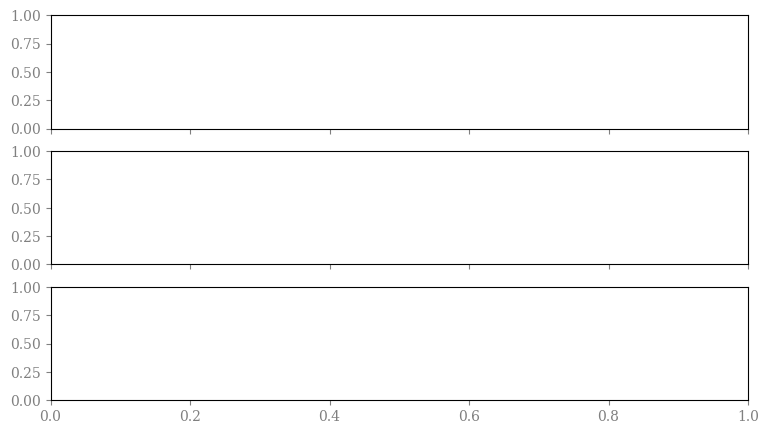

In [84]:
width = 0.25  

fig, axes = plt.subplots(3, 1, sharex=True,sharey=True, figsize=(9,5))

for i, region in zip(range(3), ['Mumbai', 'Hyderabad', 'Delhi']):

    labels = error_result.loc[region,:].index
    CVRMSE_train = error_result.loc[region,'CVRMSE_train']
    CVRMSE_test = error_result.loc[region,'CVRMSE_test']

    x = np.arange(len(labels))  
    

    rects1 = axes[i].bar(x - width/2, CVRMSE_train, width, label='Train')
    rects2 = axes[i].bar(x + width/2, CVRMSE_test, width, label='Test')

    axes[i].set_ylabel(f'{region}\nCVRMSE')
    
axes[2].set_xlabel('Prediction Method')
axes[2].set_xticks(x)
axes[2].set_xticklabels(labels, rotation=15)
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig(generate_fig_path('Figure 16'))

In [85]:
plot_time = {'summer':['2018-07-01','2018-10-01'], 'winter':['2018-12-31','2019-04-01']}

mum_predict_plot = mum_predict.drop(['train'], axis=1)
hyd_predict_plot = hyd_predict.drop(['train'], axis=1)
delhi_predict_plot = delhi_predict.drop(['train'], axis=1)

data_all = [mum_predict_plot,hyd_predict_plot,mum_predict_plot]
cities = ['Mumbai', 'Hyderabad', 'Delhi']


In [86]:
import matplotlib.dates as mdates

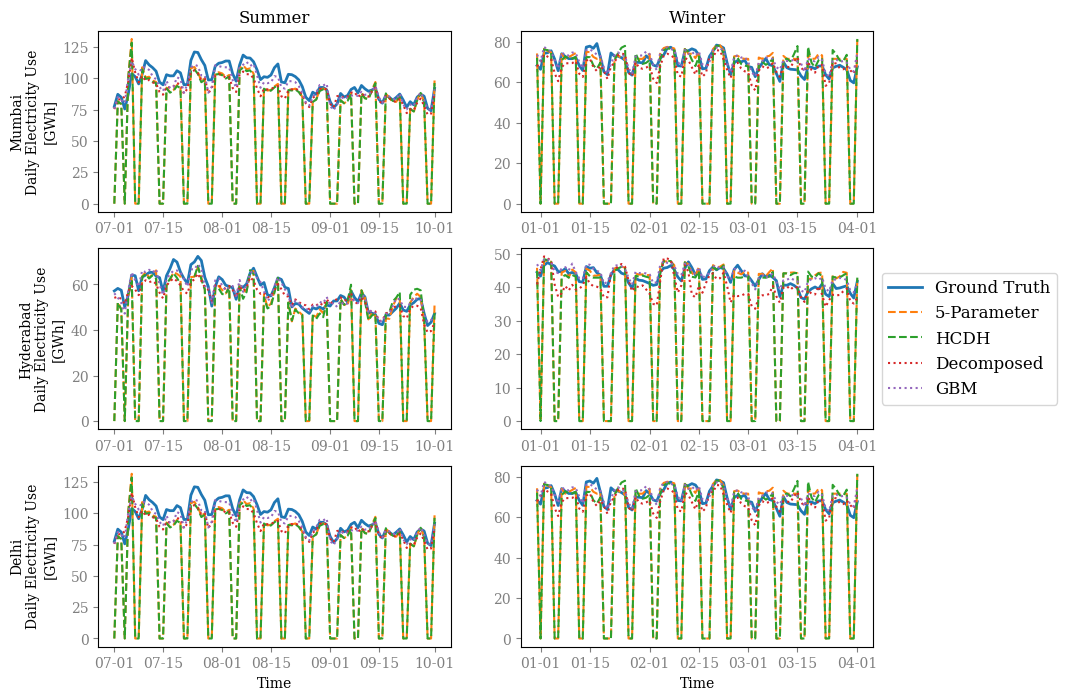

In [87]:
fig, axes = plt.subplots(3, 2, figsize=(10,8))
myFmt = mdates.DateFormatter('%m-%d')

for index in range(3):
    data = data_all[index]
    city = cities[index]
    data_summer = data.truncate(before=plot_time['summer'][0], after=plot_time['summer'][1])
    data_winter = data.truncate(before=plot_time['winter'][0], after=plot_time['winter'][1])
    
    axes[index, 0].plot(data_summer.index, data_summer['Ground Truth'].values, label='Ground Truth', linewidth=2)
    axes[index, 0].plot(data_summer.index, data_summer['5-Parameter'].values, '--', label='5-Parameter')
    axes[index, 0].plot(data_summer.index, data_summer['Degree Hour'].values, '--', label='HCDH')
    axes[index, 0].plot(data_summer.index, data_summer['Decomposed'].values, ':', label='Decomposed')
    axes[index, 0].plot(data_summer.index, data_summer['lightGBM'].values, ':', label='GBM')
    axes[index, 0].xaxis.set_major_formatter(myFmt)

    axes[index, 1].plot(data_winter.index, data_winter['Ground Truth'].values, label='Ground Truth', linewidth=2)
    axes[index, 1].plot(data_winter.index, data_winter['5-Parameter'].values, '--', label='5-Parameter')
    axes[index, 1].plot(data_winter.index, data_winter['Degree Hour'].values, '--', label='HCDH')
    axes[index, 1].plot(data_winter.index, data_winter['Decomposed'].values, ':', label='Decomposed')
    axes[index, 1].plot(data_winter.index, data_winter['lightGBM'].values, ':', label='GBM')
    axes[index, 1].xaxis.set_major_formatter(myFmt)
    
    axes[index, 0].set_ylabel(f'{city}\nDaily Electricity Use\n[GWh]')

axes[1, 1].legend(loc='center left', bbox_to_anchor=(1,0.5))
axes[0, 0].set_title('Summer')
axes[0, 1].set_title('Winter')
axes[2, 0].set_xlabel('Time')
axes[2, 1].set_xlabel('Time')

plt.savefig(generate_fig_path('Figure 15'))